In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import re
import os
import patsy

from matplotlib.colors import ListedColormap

import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from esda.adbscan import ADBSCAN
from pysal.model import mgwr
from mgwr.sel_bw import Sel_BW

import random
random.seed(42)    # For reproducibility
np.random.seed(42) # For reproducibility

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

In [2]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
%matplotlib inline

In [3]:
pip install mcdm

     |████████████████████████████████| 69 kB 194 kB/s eta 0:00:01
     |████████████████████████████████| 15.7 MB 66 kB/s eta 0:00:011   |                                | 20 kB 607 kB/s eta 0:00:26     |▍                               | 215 kB 468 kB/s eta 0:00:34     |██████████████████████████████  | 14.8 MB 3.6 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.1
    Uninstalling numpy-1.19.1:
      Successfully uninstalled numpy-1.19.1
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

pointpats 2.2.0 requires opencv-contrib-python>=4.2.0, which is not installed.
access 1.1.1 requires Sphinx==2.4.3, which is not installed.
Note: you may need to restart the kernel to use updated packages.


In [4]:
tfont = {'fontname':'Liberation Sans Narrow', 'horizontalalignment':'left'}
import math
from geopandas import GeoDataFrame
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
import mcdm

In [5]:
#加载数据
gba_area=gpd.read_file('final_output/gba_new/gba_area_withindex.shp',encoding="utf-8")
gba_station=gpd.read_file('final_output/gba_new/gba_station_withindex.shp',encoding="utf-8")
railway_grid=gpd.read_file('metro_data/mobile_grid/grid_railway_catchmentarea.shp',encoding="utf-8")
railway_flow=pd.read_csv('metro_data/mobile_grid/railway_OD_20190624.csv',low_memory=False,encoding="utf-8")

In [6]:
gba_area2=gba_area.copy()
gba_area2.to_crs('EPSG:32650',inplace=True)

In [7]:
#提取站点area的grid
railway_grid2=railway_grid.copy()
railway_grid2.to_crs('EPSG:32650',inplace=True)
test = gpd.sjoin(railway_grid2, gba_area2, how='left')
test.dropna(subset = ["id"], inplace=True)

<AxesSubplot:>

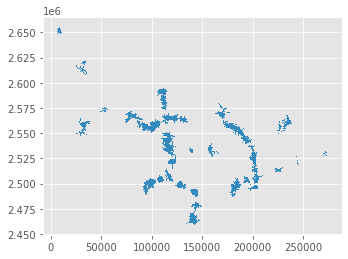

In [8]:
test.plot()

In [9]:
#加载人流
railway_flow_69 = railway_flow.groupby(['o_grid','d_grid'])['num_total'].agg(flow_day_sum='sum').reset_index()

In [10]:
#O
railway_flow_O=railway_flow_69.copy()
railway_flow_O.rename(columns={'flow_day_sum':'O_flow','o_grid':'Tid'},inplace=True)
test1=pd.merge(test,railway_flow_O,on='Tid',how='left')
test_sub=test[['Tid']]
test_sub.rename(columns={'Tid':'d_grid'},inplace=True)
test2=pd.merge(test1,test_sub,on='d_grid',how='right')
O_gba_flow = test2.groupby(['id'])['O_flow'].agg(O_flw='sum').reset_index()
gba_area=pd.merge(gba_area,O_gba_flow,on='id',how='left')

/opt/conda/envs/sds2020/lib/python3.7/site-packages/pandas/core/frame.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [11]:
railway_flow_D=railway_flow_69.copy()
railway_flow_D.rename(columns={'flow_day_sum':'D_flow','d_grid':'Tid'},inplace=True)
test1=pd.merge(test,railway_flow_D,on='Tid',how='left')
test_sub=test[['Tid']]
test_sub.rename(columns={'Tid':'o_grid'},inplace=True)
test2=pd.merge(test1,test_sub,on='o_grid',how='right')
D_gba_flow = test2.groupby(['id'])['D_flow'].agg(D_flw='sum').reset_index()
gba_area=pd.merge(gba_area,D_gba_flow,on='id',how='left')

In [12]:
gba_area.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 72 entries, 0 to 71
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   id          72 non-null     int64   
 1   area        72 non-null     float64 
 2   station_na  72 non-null     object  
 3   WGS84_Lng   72 non-null     float64 
 4   NL_NAME_2   72 non-null     object  
 5   time        72 non-null     int64   
 6   N_busStop_  72 non-null     int64   
 7   N_metro_Co  72 non-null     int64   
 8   N_train_Co  72 non-null     float64 
 9   N_external  72 non-null     float64 
 10  P_pop_sum   72 non-null     int64   
 11  N_translan  72 non-null     float64 
 12  P_basic_Co  72 non-null     float64 
 13  P_unbasic_  72 non-null     float64 
 14  P_LUM       72 non-null     float64 
 15  P_poi_Dive  72 non-null     float64 
 16  Node_index  72 non-null     float64 
 17  Place_inde  72 non-null     float64 
 18  geometry    72 non-null     geometry
 19  O_

In [13]:
gba_area.sum(axis = 0, skipna = True)
##该时段流动的总人口3686830

id                                                         2722
area                                         1,294,080,174.2940
station_na    ??????????????????????????????????????????????...
WGS84_Lng                                            8,171.3194
NL_NAME_2     ??????????????????????????????????????????????...
time                                                        720
N_busStop_                                                64356
N_metro_Co                                                  147
N_train_Co                                           4,526.0000
N_external                                              33.4480
P_pop_sum                                              12958330
N_translan                                               3.8949
P_basic_Co                                              27.0434
P_unbasic_                                              22.6134
P_LUM                                                   50.2553
P_poi_Dive                              

In [14]:
gba_area['centricity_index']=(gba_area.D_flw-gba_area.O_flw)/3686830

In [15]:
###计算functional polycentricity
railway_flow_O=railway_flow_69.copy()
railway_flow_O.rename(columns={'flow_day_sum':'O_flow','o_grid':'Tid'},inplace=True)
temp1=pd.merge(test,railway_flow_O,on='Tid',how='left')
temp_sub=test[['Tid','id']]
temp_sub.rename(columns={'Tid':'d_grid','id':'D_id'},inplace=True)
gba_within_flow=pd.merge(temp1,temp_sub,on='d_grid',how='right')
gba_flow = gba_within_flow.groupby(['id','D_id'])['O_flow'].agg(flw='sum').reset_index()


In [16]:
gba_flow

,id,D_id,flw
0,1.0000,1.0000,"17,255.0000"
1,1.0000,2.0000,132.0000
2,1.0000,3.0000,89.0000
3,1.0000,4.0000,103.0000
4,1.0000,5.0000,45.0000
...,...,...,...
4215,74.0000,70.0000,66.0000
4216,74.0000,71.0000,108.0000
4217,74.0000,72.0000,"5,439.0000"
4218,74.0000,73.0000,"1,829.0000"


In [17]:
import networkx as nx
G_gba = nx.Graph()
G_gba = nx.from_pandas_edgelist(gba_flow, 'id', 'D_id',['flw'],create_using=nx.DiGraph)

In [18]:
#degree for each node
deg=nx.degree(G_gba,weight='flw')
deg

DiDegreeView({1.0: 40547.0, 2.0: 44960.0, 3.0: 54038.0, 4.0: 33933.0, 5.0: 23745.0, 7.0: 86476.0, 8.0: 261007.0, 9.0: 106761.0, 10.0: 57439.0, 11.0: 108884.0, 12.0: 98388.0, 13.0: 22355.0, 14.0: 114835.0, 15.0: 420473.0, 16.0: 40016.0, 17.0: 389581.0, 18.0: 5249.0, 19.0: 18335.0, 20.0: 41264.0, 22.0: 310.0, 23.0: 100617.0, 24.0: 172722.0, 25.0: 341853.0, 28.0: 129601.0, 29.0: 347601.0, 30.0: 126324.0, 31.0: 18538.0, 35.0: 888.0, 36.0: 75977.0, 37.0: 103761.0, 38.0: 60874.0, 39.0: 75000.0, 40.0: 14238.0, 41.0: 18414.0, 42.0: 397895.0, 43.0: 595905.0, 44.0: 278893.0, 45.0: 67507.0, 46.0: 2933.0, 47.0: 54199.0, 48.0: 16446.0, 49.0: 23020.0, 50.0: 144744.0, 51.0: 191300.0, 52.0: 193561.0, 53.0: 226483.0, 54.0: 322122.0, 55.0: 153432.0, 56.0: 21767.0, 57.0: 27528.0, 58.0: 18276.0, 59.0: 16466.0, 60.0: 151944.0, 61.0: 10215.0, 62.0: 17767.0, 63.0: 48696.0, 64.0: 46657.0, 65.0: 27001.0, 66.0: 303824.0, 67.0: 36626.0, 68.0: 56658.0, 69.0: 53357.0, 70.0: 65913.0, 71.0: 14020.0, 72.0: 112833.0, 

In [19]:
gba_den=nx.density(G_gba)
gba_degree = pd.DataFrame(dict(
    DEGREE = dict(deg)))
gba_degree['id']=gba_degree.index.values
gba_area=pd.merge(gba_area,gba_degree,on='id',how='left')

In [20]:
from statistics import stdev
sample=(gba_area.DEGREE.min(),gba_area.DEGREE.max())
gba_FP=gba_den*(1-(gba_area.DEGREE.std())/(stdev(sample)))
gba_FP
###GBAfunctional polycentricity——————0.5845052755295869

0.5845052755295869

In [21]:
temp=gba_area[['centricity_index','DEGREE','id']]
gba_station=pd.merge(gba_station,temp,on='id',how='left')
gba_station.to_file("gba_station_withcentricity.shp")
gba_area.to_file("gba_area_withcentricity.shp")